<h1 align='center'> SMC - TD2 </h1>
<h4 align='right'><i> author: Hicham Janati </i></h4>
<h3> Algorithme de rejet </h3>

In [65]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt

## 1 - Laplace Generator with inverse sampling
Soit $U \sim \mathcal U([0, 1])$ et $X$ une var suivant une loi $\mu$, de fonction de répartition $F$ admettant une réciproque $F^{-1}$. Le <a href=https://en.wikipedia.org/wiki/Inverse_transform_sampling> théorème d'inversion </a> assure que la var $F^{-1}(U)$ suit la loi $\mu$. Ainsi, pour générer un échantillon $X_1, \dots, X_n$ suivant la loi de Laplace, il suffit d'inverser sa fonction de répartition et l'appliquer à U.

Pour une loi de la place on a:

$$F(t) = \left\{
                \begin{array}{l}
                  \frac{1}{2} e^{x} \text{ si }x \leq 0 \\
                  1 - \frac{1}{2}e^{-x} \text{ si } x \geq 0 \\
                \end{array}
         \right.
$$

Et donc:

$$\forall u \in [0, 1] \qquad F^{-1}(u) = \left\{
                \begin{array}{l}
                  \log(2u) \text{ si } u \leq \frac{1}{2} \\
                  \log(2 - 2u) \text{ si } u \geq \frac{1}{2} \\
                \end{array}
         \right.
$$


In [66]:
# with lists 
def laplace_list(n, seed=None):
    """Laplace generator.
    n: int.
        number of samples.
    seed: int (optional).
        random seed initialization.
    """
    # init generator
    rnd = np.random.RandomState(seed)
    L = []
    for i in range(n):
        u = rnd.rand()
        if u <= 0.5:
            L.append(np.log(2 * u))
        else:
            L.append(- np.log(2 - 2 * u))
    return L

In [67]:
%%timeit
x = laplace_list(10000, seed=0)

100 loops, best of 3: 18.6 ms per loop


C'est cool mais avec Numpy c'est plus efficace (et plus beau):

In [68]:
def laplace(n, seed=None):
    """Laplace generator.
    n: int.
        number of samples.
    seed: int (optional).
        random seed initialization.
    """
    rnd = np.random.RandomState(seed)
    U = rnd.rand(n) # generate random sample U of size n
    mask = U < 0.5 # boolean array 
    L1 = mask * np.log(2 * U) # when u < 0.5 (not concerned entries are zero, the others are 0)
    L2 = - (1 - mask) * np.log(2 - 2 * U) # when u > 0.5
    L = L1 + L2
    return L

In [69]:
%%timeit
n = 10000
L = laplace(n, 0)

The slowest run took 36.57 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 520 µs per loop


On plot la vraie densité et la compare avec un histogramme de L:

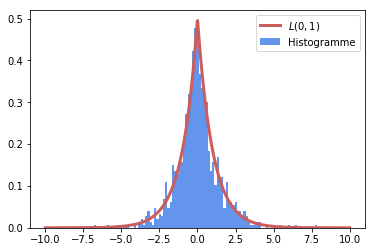

In [70]:
x = np.linspace(-10, 10, n) # vector of n numbers between -10 and 10
densite = 0.5 * np.exp(- abs(x))
plt.figure()
plt.plot(x, densite, color='indianred', linewidth=3, label=r"$L(0, 1)$")
plt.hist(L, bins=100, color='cornflowerblue', label='Histogramme', normed=True)
plt.legend()
plt.show()

## 2 - Laplace Generator with reject algorithm
En se basant sur la loi de Laplace, on génère un échantillon suivant la loi Normale centrée réduite. On cherche donc à majorer pour tout $x$ la densité gaussienne: $$ f(x) = \frac{1}{2\pi} \exp(-x^2 / 2) $$ par une constante M fois la densité de Laplace: $$ M g(x) = M \frac{1}{2} \exp{- |x|} $$. 

Pour générer N observations:
- List = []
- for i in [1, n]:
        1. x sampled from g
        2. u sampled from U[0, 1]
        3. if u < f(x) / Mg(x):
                add x to List
           else: 
               repeat 1., 2., 3.
        
Comme la probabilité d'acceptation est donnée par 1 / M (<a href=http://www.columbia.edu/~ks20/4703-Sigman/4703-07-Notes-ARM.pdf> Proof here </a>), on cherche à ce que M soit la plus petite valeure possible:
On prend donc:
$$ M = \sup_x f(x)/g(x) = \sqrt{\frac{2}{\pi}}\sup_x \exp(-x^2 / 2 + |x|) = \sqrt{\frac{2 e}{\pi}} $$

Créons deux fonctions f et g (les densités) en utilisant l'expression `lambda`:

In [71]:
f = lambda x : np.exp(- x ** 2 / 2) / np.sqrt(2 * np.pi)
g = lambda x : 0.5 * np.exp(- abs(x))

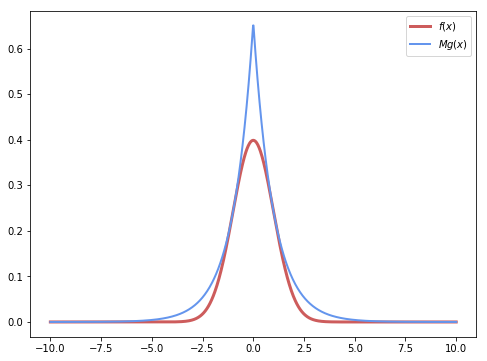

In [72]:
n = 1000
M = np.sqrt((2 * np.e) / np.pi )
x = np.linspace(-10, 10, n)
plt.figure(figsize=(8, 6))
plt.plot(x, f(x), color='indianred', lw=3, label=r"$f(x)$")
plt.plot(x, M * g(x), color='cornflowerblue', lw=2, label=r"$Mg(x)$")
plt.legend()
plt.show()

In [73]:
def gaussian(n, f=f, g=g, M=M, seed=None):
    """Gaussian generator with reject algorithm.
    n: int.
        number of samples.
    f: callable.
        density we want to sample from.
    g: callable.
        density we use as surrogate.
    M: float > 1.
        bound constant f < M g.
    seed: int (optional).
        random seed initialization.
    """
    rnd = np.random.RandomState(seed)
    Y = np.zeros(n) # liste que l'on remplit avec des x ~ N(0, 1)
    j = 0 # compteur du nombre total d'essais
    for i in range(n):
        while(True):
            j += 1
            x = rnd.laplace()
            u = rnd.rand()
            if M * g(x) * u <= f(x):
                break
        Y[i] = x
    return Y, j

In [74]:
N = 100000
Y, j = gaussian(N, f, g, M)

On plot la vraie densité et la compare avec un histogramme de X:

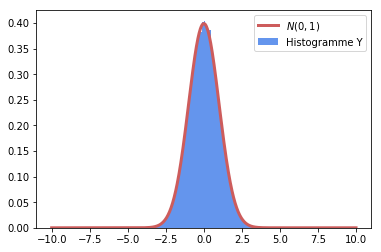

In [75]:
x = np.linspace(-10, 10, n) # vector of n numbers between -10 and 10
plt.figure()
plt.plot(x, f(x), color='indianred', linewidth=3, label=r"$N(0, 1)$")
plt.hist(Y, bins=100, color='cornflowerblue', label='Histogramme Y', normed=True)
plt.legend()
plt.show()

### 3 - Taux d'acceptation

On a accepté N / j. Empiriquement:

In [76]:
N / j

0.7614812332950055

Et théoriquement:

In [77]:
1 / M

0.7601734505331403

La contrainte d'acceptation est optimale.

### 4 - Générer Laplace à partir de Gauss ?

Non car on ne peut pas majorer g par f car les queues de la distribution gaussienne tendent en exp(-x^2) vers 0 (et en exp(-x) pour g). On plot le rapport g / f:

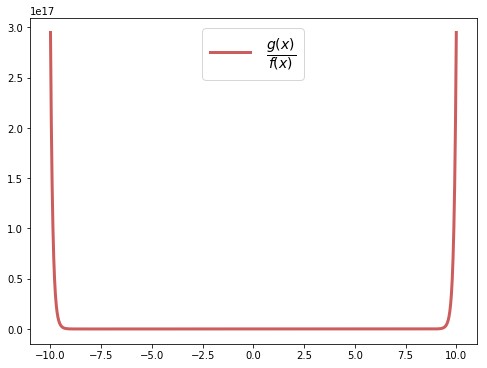

In [78]:
n = 1000
x = np.linspace(-10, 10, n)
plt.figure(figsize=(8, 6))
plt.plot(x, g(x) / f(x), color='indianred', lw=3, label=r"$\frac{g(x)}{f(x)}$")
plt.legend(fontsize=20)
plt.show()